1. Define necessary modules, class, functions

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from data_loader import CustomSignalData, CustomSignalData1
from torch.autograd import Variable
from encoder import Encoder as E
from helpers import set_cmd_cb, rms_formuula, get_data, get_all_data, get_shift_data, get_operators, plot_cfs_mat, roll_data

DEVICE = torch.device("cpu")
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

class FFNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(FFNN, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inputSize, 9, bias=False),
            torch.nn.Sigmoid()
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(9, outputSize, bias=False),
            # torch.nn.Softmax(dim=1)
        )

    def forward(self, x, encoder=None):
        if not encoder:
            encoder = self.encoder
        z = encoder(x)
        class_z = self.classifer(z)

        return class_z

class Operator(nn.Module):
    def __init__(self, in_features, n_rotations):
        super(Operator, self).__init__()
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.core = torch.nn.Parameter(torch.zeros(3*self.in_features**2)- 0*torch.diag(torch.rand(3*self.in_features**2)/10))
        self.core.requires_grad = True
        self.n_rotations = n_rotations
        
    def rotate_batch(self, x, d, out_features):
      rotated = torch.empty(x.shape[0], 3*out_features*out_features, device=DEVICE)
      phies = [torch.linalg.matrix_power(self.core,i).to(DEVICE) for i in range (0,self.n_rotations+0)]
      for i in range (x.shape[0]):
        rotated[i] = phies[(d[i]+0)%4].matmul(x[i]) 
      return rotated

    def forward(self, x, d):
        """
        Args:
          x of shape (batch_size, 3, xsize, xsize): Inputs.
        
        Returns:
          y of shape (batch_size, 3*xsize^2): Outputs.
        """
        z = self.rotate_batch(x, d, self.in_features)
        return z
def get_tensor(arr):
    return torch.tensor(arr, device=DEVICE,dtype=torch.float )

def rotate_batch(x, d, out_features):
    M = torch.diag(torch.ones(8)).roll(-1,1)
    used_bases = [torch.linalg.matrix_power(M,i).to(DEVICE) for i in range (8)]
    rotated = torch.empty(x.shape, device=DEVICE)
    for i in range (x.shape[0]):
        rotated[i] = used_bases[d[i]].matmul(x[i]) 
    return rotated

def clf_acc(model, loader, masks = None, encoder = None):
    model.eval()
    correct = 0
    iter = 0
    with torch.no_grad():
        for inputs, labels,_,_ in loader:
            inputs = inputs.to(DEVICE)
            if masks is not None:
                inputs = inputs * masks[:inputs.size()[0]]
            labels = labels.to(DEVICE)
            labels = labels.flatten()
            if encoder:
                pred = model(inputs, encoder)
            else:
                pred = model(inputs)
            correct += (1-torch.abs(torch.sign(torch.argmax(pred,dim = 1)- labels))).mean().item()
            iter += 1
    return correct/iter

def compute_accuracy(a, b, loader):
    a.eval()
    b.eval()
    
    correct = 0
    iter = 0
    
    with torch.no_grad():
        for inputs1, inputs2, shift1, shift2, labels, _ in loader:
            inputs1 = inputs1.to(DEVICE)
            inputs2 = inputs2.to(DEVICE)
            shift1 = -shift1.int().flatten().to(DEVICE)
            shift2 = -shift2.int().flatten().to(DEVICE)
            labels = labels.flatten().to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            y1 = a(inputs1)
            y_tr_est1 = rotate_batch(y1,shift1,6)
            y_tr1 = b(y_tr_est1)

            y2 = a(inputs2)
            y_tr_est2 = rotate_batch(y2,shift1,6)
            y_tr2 = b(y_tr_est2)

            correct += (1-torch.abs(torch.sign(torch.argmax(y_tr1,dim = 1)- labels))).mean().item() + \
                    (1-torch.abs(torch.sign(torch.argmax(y_tr2,dim = 1)- labels))).mean().item()
            iter += 1
    return correct * 0.5 / iter

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2. Train and Test at the same physical position shifting itself: 3 fold validation

2.1 Load Data: Data is 4 dimensions with order from outside: 9 shifts, 3 folds, 9 classes, array data

In [56]:
subject = '26'

Fs = 1000
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

X_train = [[np.zeros([0, 8]) for _ in range(3)] for _ in range(9)]
y_train = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]
X_test = [[np.zeros([0, 8]) for _ in range(3)] for _ in range(9)]
y_test = [[np.zeros([0]) for _ in range(3)] for _ in range(9)]


for k_fold in range(0, 3): 
    for shift in range(0,9): 
        for files in sorted(os.listdir(f'Subject_{subject}/Shift_{shift}/')):
            _, class_,_, rep_ = files.split('_')
            
            df = pd.read_csv(f'Subject_{subject}/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            if not class_.startswith('9'):
                rms_feature = feaData.sum(0)
                baseline = 2*rms_feature[-50:].mean()
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            
            
            if rep_.startswith(str(k_fold+1)):
                X_test[shift][k_fold] = np.concatenate([X_test[0][k_fold],feaData])
                y_test[shift][k_fold] = np.concatenate([y_test[0][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                X_train[shift][k_fold] = np.concatenate([X_train[0][k_fold],feaData])
                y_train[shift][k_fold] = np.concatenate([y_train[0][k_fold],np.ones_like(feaData)[:,0]*int(class_)-1])



In [58]:
print("Training dataset feature:")
print(X_train[0][0].shape)
print("Training dataset label:")
print(y_train[0][0].shape)
print("Testing dataset feature:")
print(X_test[0][0].shape)
print("Testing dataset label:")
print(y_test[0][0].shape)

Training dataset feature:
(4757, 8)
Training dataset label:
(4757,)
Testing dataset feature:
(2351, 8)
Testing dataset label:
(2351,)


2.2 Logistic Regression:

2.2.1: Training leanring model

In [59]:
accuracies_LosReg_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        reg = LogisticRegression(penalty='l2', C=100).fit(X_train[shift][k_fold], y_train[shift][k_fold])
        dump(reg, f'LogisticRegression_fold_{k_fold+1}_shift_{shift}.joblib')
        

/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/eea-10/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

2.2.2 Testing accuracy

In [60]:
accuracies_LosReg_list = [[0 for _ in range(3)] for _ in range(9)]
for shift in range(9):
    for k_fold in range(3):
        logRegres  = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}.joblib')
        accuracy = logRegres.score(X_test[shift][k_fold],y_test[shift][k_fold])
        accuracies_LosReg_list[shift][k_fold]= accuracy
        print(f'Accuracy of shift {shift} fold {k_fold+1}:')
        print(accuracy)

Accuracy of shift 0 fold 1:
0.9476818375159507
Accuracy of shift 0 fold 2:
0.9129154396297855
Accuracy of shift 0 fold 3:
0.8991596638655462
Accuracy of shift 1 fold 1:
0.9521158129175946
Accuracy of shift 1 fold 2:
0.9234972677595629
Accuracy of shift 1 fold 3:
0.908256880733945
Accuracy of shift 2 fold 1:
0.9534970238095238
Accuracy of shift 2 fold 2:
0.9203084832904884
Accuracy of shift 2 fold 3:
0.9121969140337987
Accuracy of shift 3 fold 1:
0.9545454545454546
Accuracy of shift 3 fold 2:
0.9228224917309813
Accuracy of shift 3 fold 3:
0.9149484536082474
Accuracy of shift 4 fold 1:
0.9516008935219658
Accuracy of shift 4 fold 2:
0.9222797927461139
Accuracy of shift 4 fold 3:
0.9119056395134537
Accuracy of shift 5 fold 1:
0.9534797171566803
Accuracy of shift 5 fold 2:
0.9212165628435325
Accuracy of shift 5 fold 3:
0.9119705340699816
Accuracy of shift 6 fold 1:
0.9542240416821735
Accuracy of shift 6 fold 2:
0.9227927595123753
Accuracy of shift 6 fold 3:
0.9137931034482759
Accuracy of sh

2.2.2.1 Accuracy of each 9 hardware shift with 3 accuracies in each represnt for 3 folds

In [63]:
print(accuracies_LosReg_list)

[[0.9476818375159507, 0.9129154396297855, 0.8991596638655462], [0.9521158129175946, 0.9234972677595629, 0.908256880733945], [0.9534970238095238, 0.9203084832904884, 0.9121969140337987], [0.9545454545454546, 0.9228224917309813, 0.9149484536082474], [0.9516008935219658, 0.9222797927461139, 0.9119056395134537], [0.9534797171566803, 0.9212165628435325, 0.9119705340699816], [0.9542240416821735, 0.9227927595123753, 0.9137931034482759], [0.9530026109660574, 0.9255436785845927, 0.914306730415594], [0.9546805349182764, 0.9227642276422764, 0.9113553113553113]]


In [ ]:
# accuracies_LosReg_list = [
#     [0.9476818375159507, 0.9129154396297855, 0.8991596638655462],
#     [0.9521158129175946, 0.9234972677595629, 0.908256880733945],
#     [0.9534970238095238, 0.9203084832904884, 0.9121969140337987],
#     [0.9545454545454546, 0.9228224917309813, 0.9149484536082474],
#     [0.9516008935219658, 0.9222797927461139, 0.9119056395134537],
#     [0.9534797171566803, 0.9212165628435325, 0.9119705340699816],
#     [0.9542240416821735, 0.9227927595123753, 0.9137931034482759],
#     [0.9530026109660574, 0.9255436785845927, 0.914306730415594],
#     [0.9546805349182764, 0.9227642276422764, 0.9113553113553113]
# ]

2.2.2.2 Accuracy of each 9 hardware shift average from 3 folds

In [64]:
average_accuracies_LosReg_list = []
for accuracy in accuracies_LosReg_list:
    average_accuracies_LosReg_list.append(sum(accuracy)/3)


In [65]:
print(average_accuracies_LosReg_list)

[0.9199189803370942, 0.9279566538037008, 0.9286674737112702, 0.9307721332948944, 0.9285954419271777, 0.9288889380233982, 0.9302699682142749, 0.9309510066554147, 0.9296000246386215]


2.2.2.3 Accuarcy average total of 9 hardware shitfs

In [66]:
value_average_accuracies_LosReg = sum(average_accuracies_LosReg_list) / 9 
print(value_average_accuracies_LosReg)

0.9284022911784273


2.2.3 Plot the graph

2.2.3.1 Average accuracy in 9 hardwrae shifts

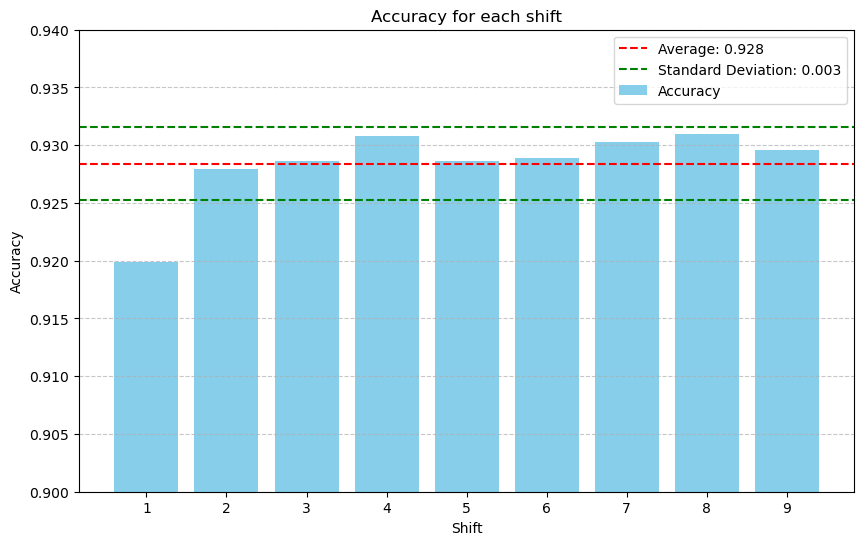

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Data

shifts = range(1, len(average_accuracies_LosReg_list) + 1)

# Calculate average and standard deviation
avg_accuracy = np.mean(average_accuracies_LosReg_list)
std_deviation = np.std(average_accuracies_LosReg_list)

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(shifts, average_accuracies_LosReg_list, color='skyblue', label='Accuracy')

# Plot average and standard deviation
plt.axhline(y=avg_accuracy, color='red', linestyle='--', label=f'Average: {avg_accuracy:.3f}')
plt.axhline(y=avg_accuracy + std_deviation, color='green', linestyle='--', label=f'Standard Deviation: {std_deviation:.3f}')
plt.axhline(y=avg_accuracy - std_deviation, color='green', linestyle='--')

# Add labels and title
plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.title('Accuracy for each shift')

# Set y-axis limits
plt.ylim(0.9, 0.94)

# Show legend
plt.legend()

# Show plot
plt.xticks(shifts)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.show()


2.2.3.2 Confusion matrix in each 9 hardwrae shifts between 9 classes

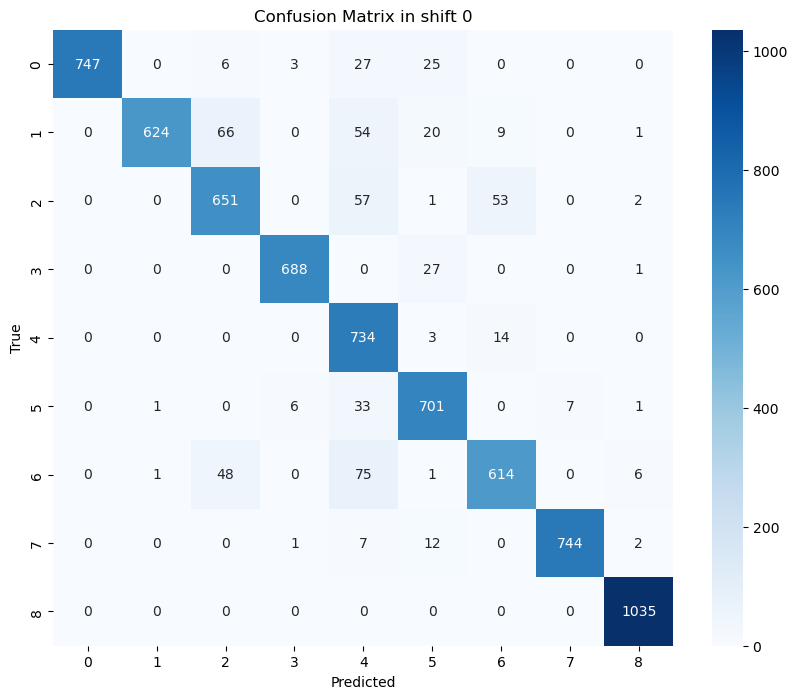

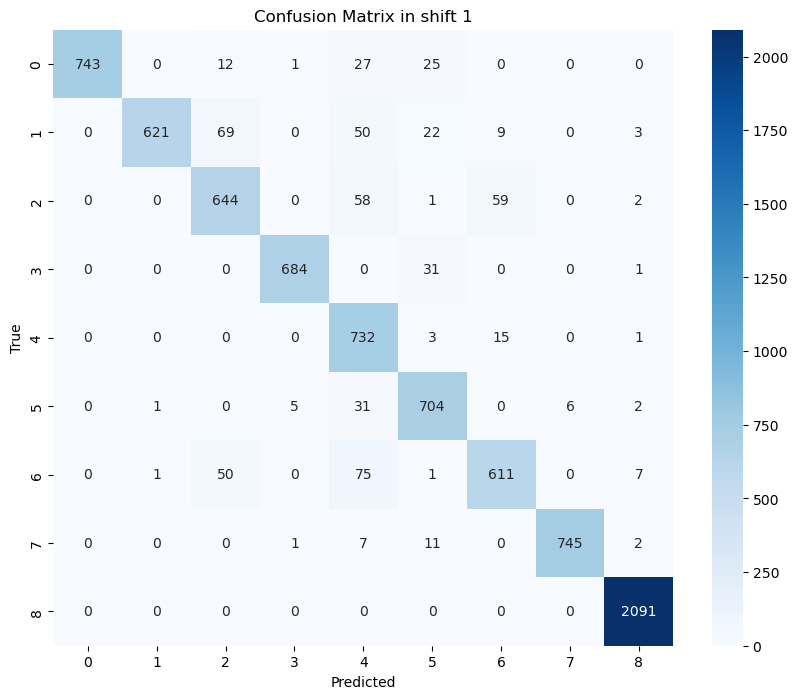

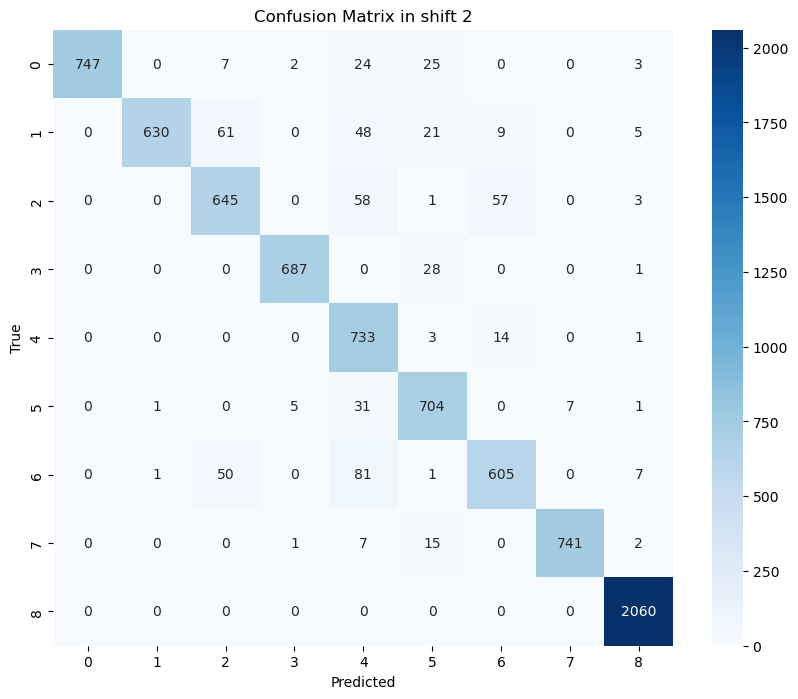

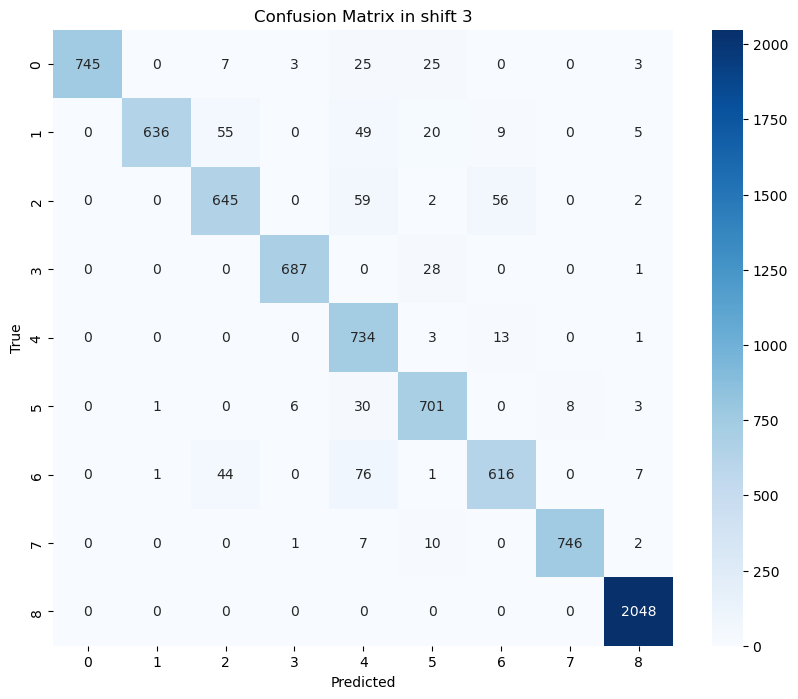

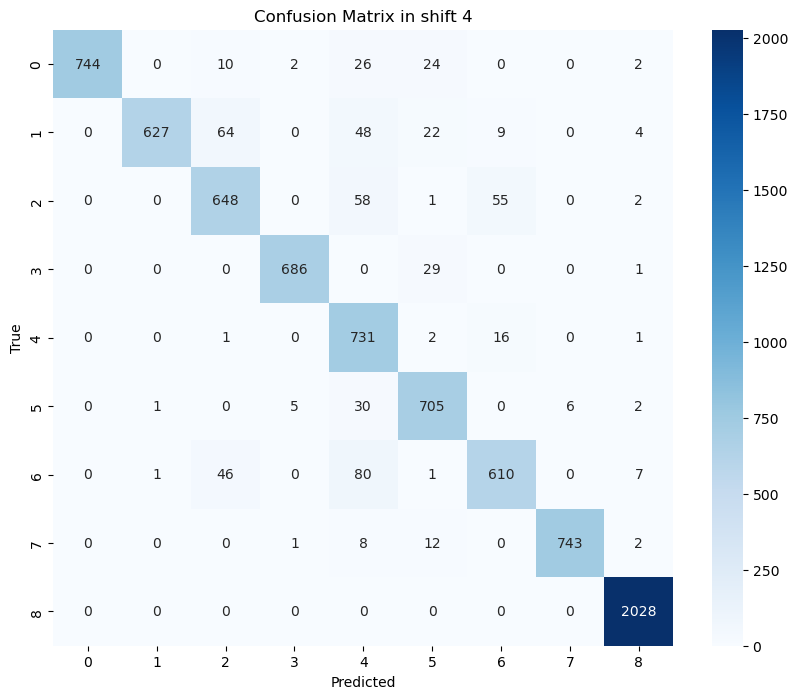

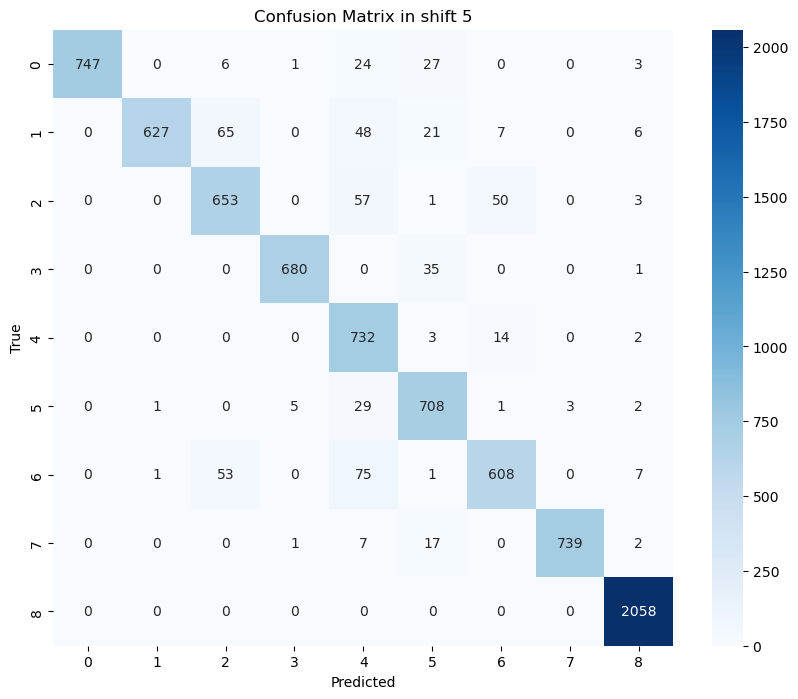

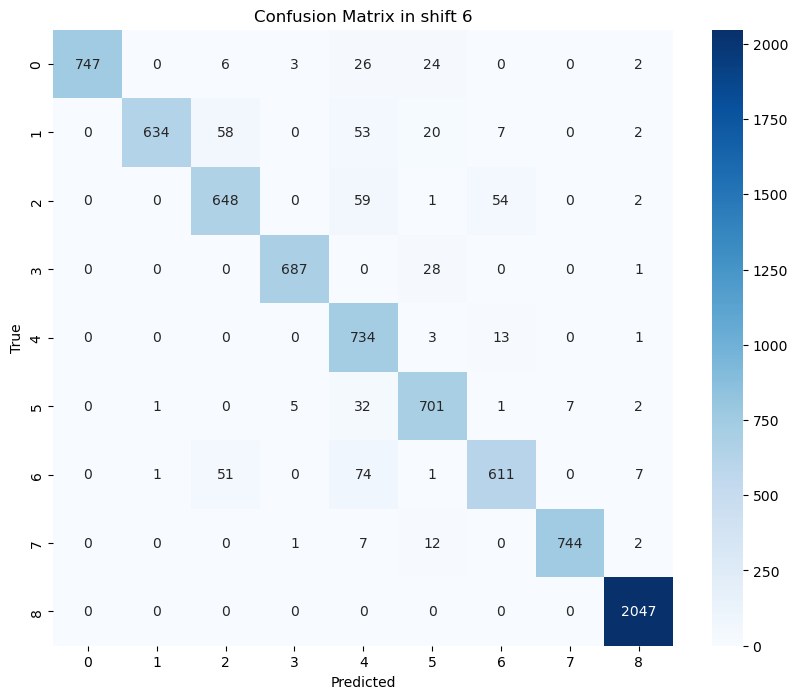

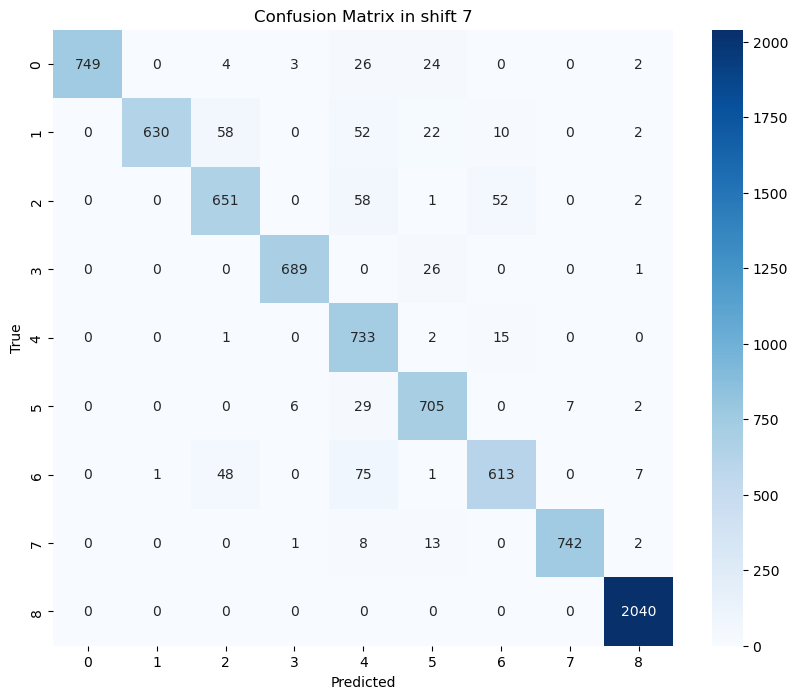

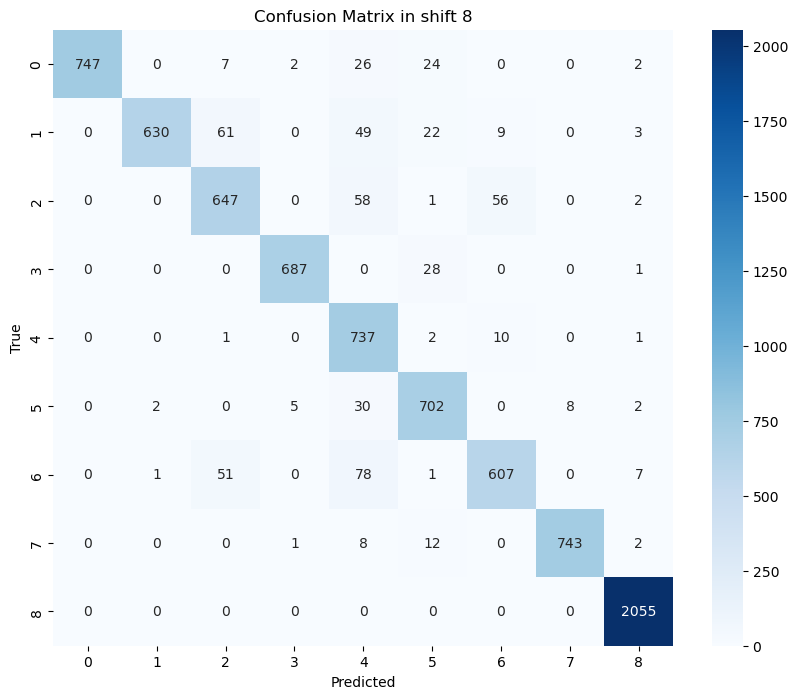

In [81]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize variables to accumulate predictions and true labels
all_predictions = []
all_true_labels = []
conf_matrices_list = []

# Loop through shifts and folds
for shift in range(9):
    all_predictions = []
    all_true_labels = []
    for k_fold in range(3):

        # Load the trained model
        reg = load(f'LogisticRegression_fold_{k_fold+1}_shift_{shift}.joblib')

        # Make predictions on the test data
        predictions = reg.predict(X_test[shift][k_fold])
        
        # Accumulate predictions and true labels
        all_predictions.extend(predictions)
        all_true_labels.extend(y_test[shift][k_fold])
        
        # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predictions)
    conf_matrices_list.append(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix in shift {shift}')
    plt.show()



Confusion matrix: average of 9 shifts in each positions from 9 confusion matrix above

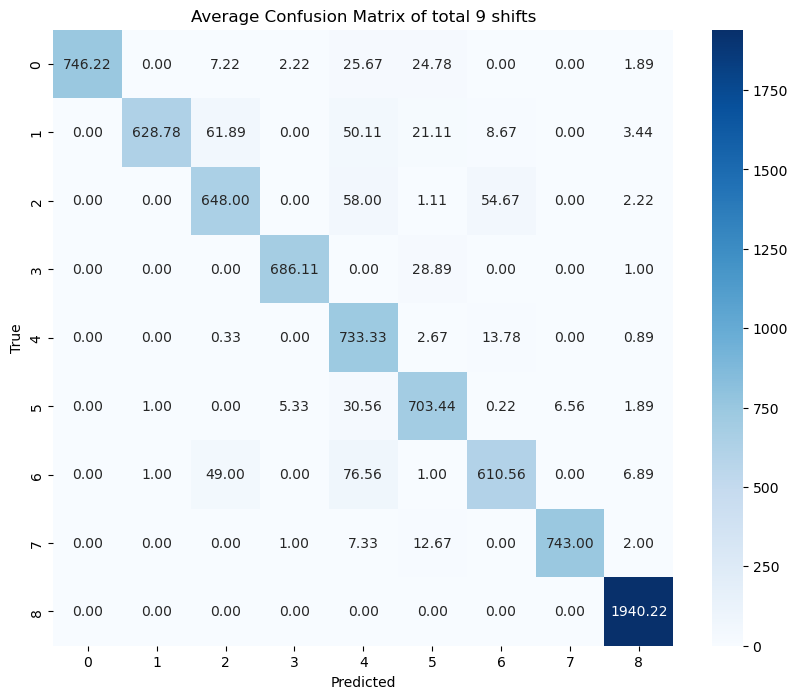

In [82]:
average_conf_matrix = np.mean(conf_matrices_list, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(average_conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix of total 9 shifts')
plt.show()